In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Extracting audio files from zip file

In [ ]:
import zipfile
import os
zippath = '/content/drive/MyDrive/PBL_2_Files/SpeechData.zip'
dpath = '/content/drive/MyDrive/PBL_2_Files/SpeechData'
with zipfile.ZipFile(zippath, 'r') as zip_ref:
    zip_ref.extractall(dpath)
print("Extracted all audio files")

Extracted all audio files


In [ ]:
import librosa, os, cv2, pickle, tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

### **Exploratory Data Analysis**

In [ ]:
dpath = '/content/drive/MyDrive/PBL_2_Files/SpeechData'
audio_path = os.path.join(dpath,"Actor_01/03-01-03-01-01-01-01.wav")
y, sr = librosa.load(audio_path,sr=48000)
print(y.shape)
print(sr)

(166567,)
48000


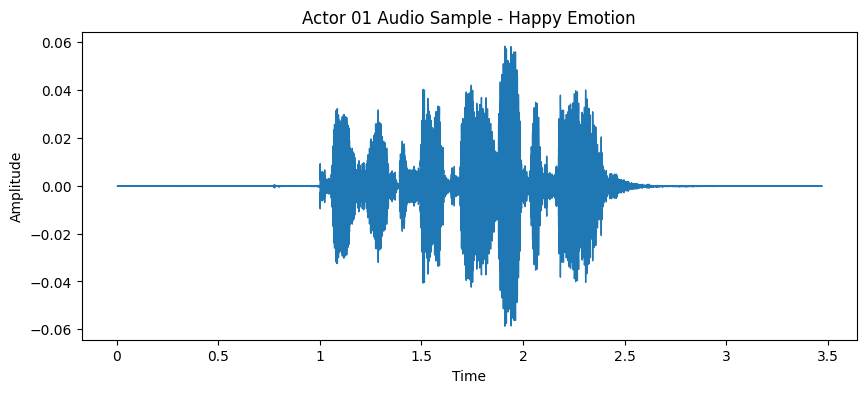

In [ ]:
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title("Actor 01 Audio Sample - Happy Emotion")
plt.ylabel("Amplitude")
plt.show()

#### Plotting one sample from each emotion class for comparison

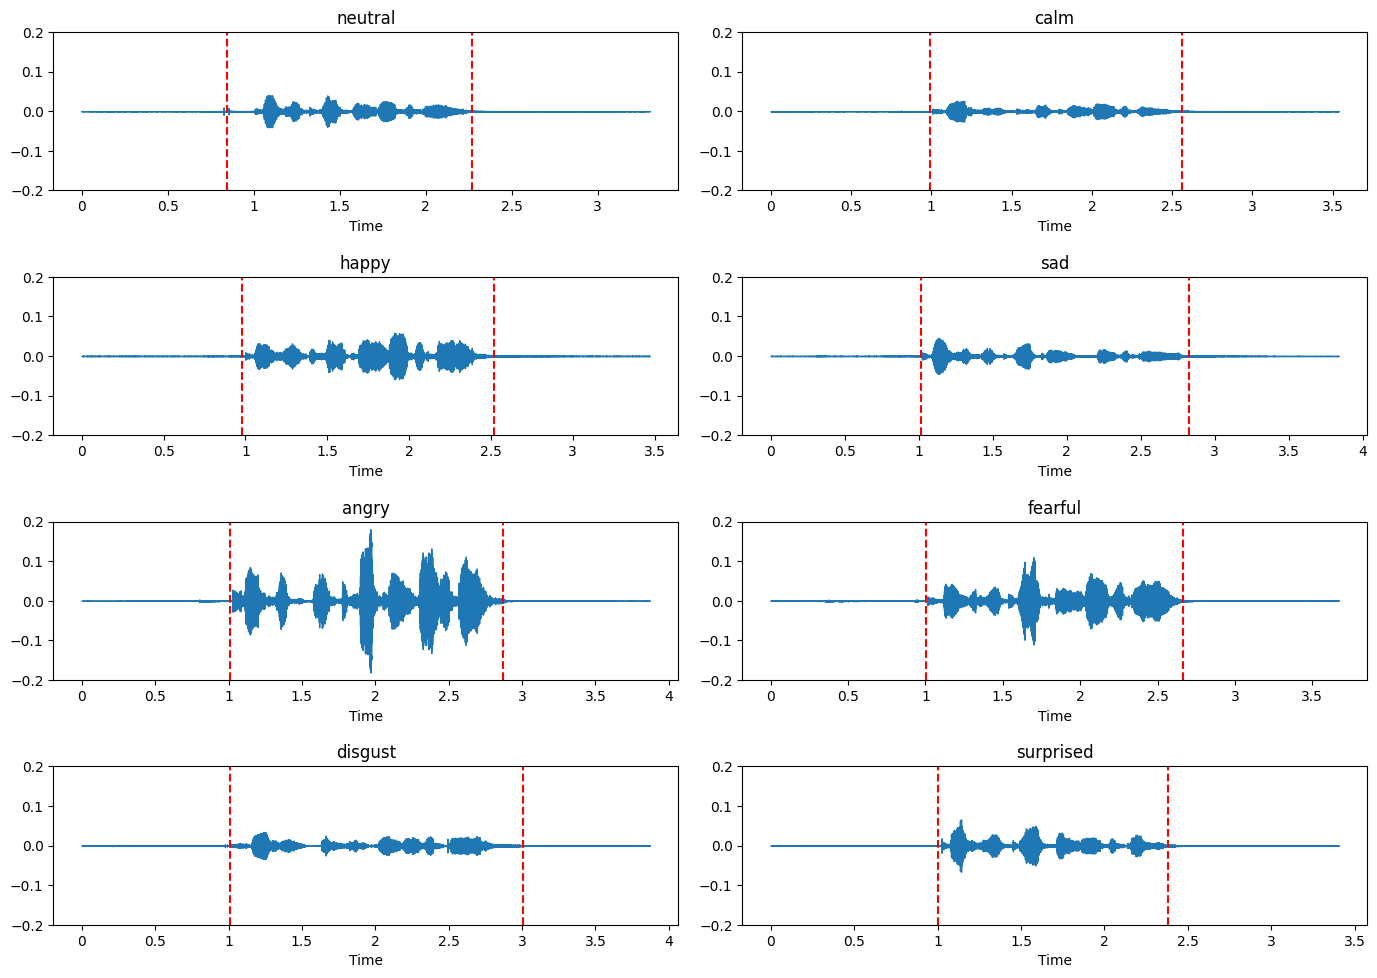

In [ ]:
labels = { '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad', '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised' }
plt.figure(figsize=(14, 10))
for i in range(1,9):
  audio_path = os.path.join(dpath,f"Actor_01/03-01-0{i}-01-01-01-01.wav")
  y, sr = librosa.load(audio_path,sr=48000)
  ytrim, index = librosa.effects.trim(y,top_db=30)
  plt.subplot(4,2,i)
  plt.title(labels[f'0{i}'])
  plt.ylim(-0.2,0.2)
  dur = librosa.get_duration(y=y,sr=sr)
  plt.axvline(x=dur/len(y)*index[0], color='r', linestyle='--')
  plt.axvline(x=dur/len(y)*index[1], color='r', linestyle='--')
  librosa.display.waveshow(y, sr=sr)
plt.tight_layout(pad=1.5)
plt.show()

#### Plotting after clipping silent parts

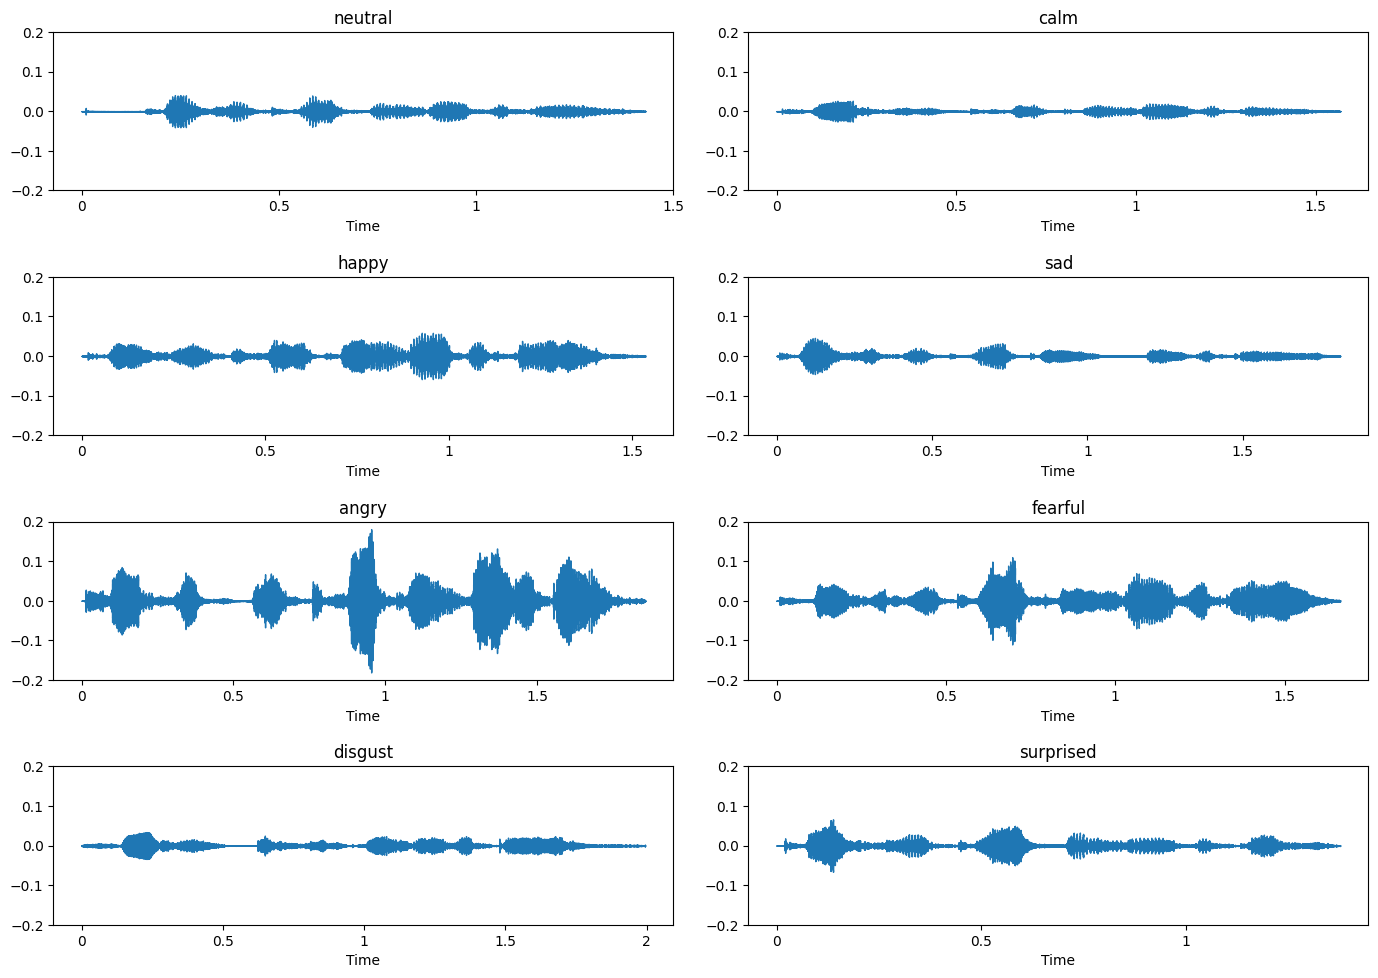

In [ ]:
plt.figure(figsize=(14, 10))
for i in range(1,9):
  audio_path = os.path.join(dpath,f"Actor_01/03-01-0{i}-01-01-01-01.wav")
  y, sr = librosa.load(audio_path,sr=48000)
  ytrim, index = librosa.effects.trim(y,top_db=30)
  plt.subplot(4,2,i)
  plt.title(labels[f'0{i}'])
  plt.ylim(-0.2,0.2)
  librosa.display.waveshow(ytrim, sr=sr)
plt.tight_layout(pad=1.5)
plt.show()

#### Plotting their Mel-Spectrograms

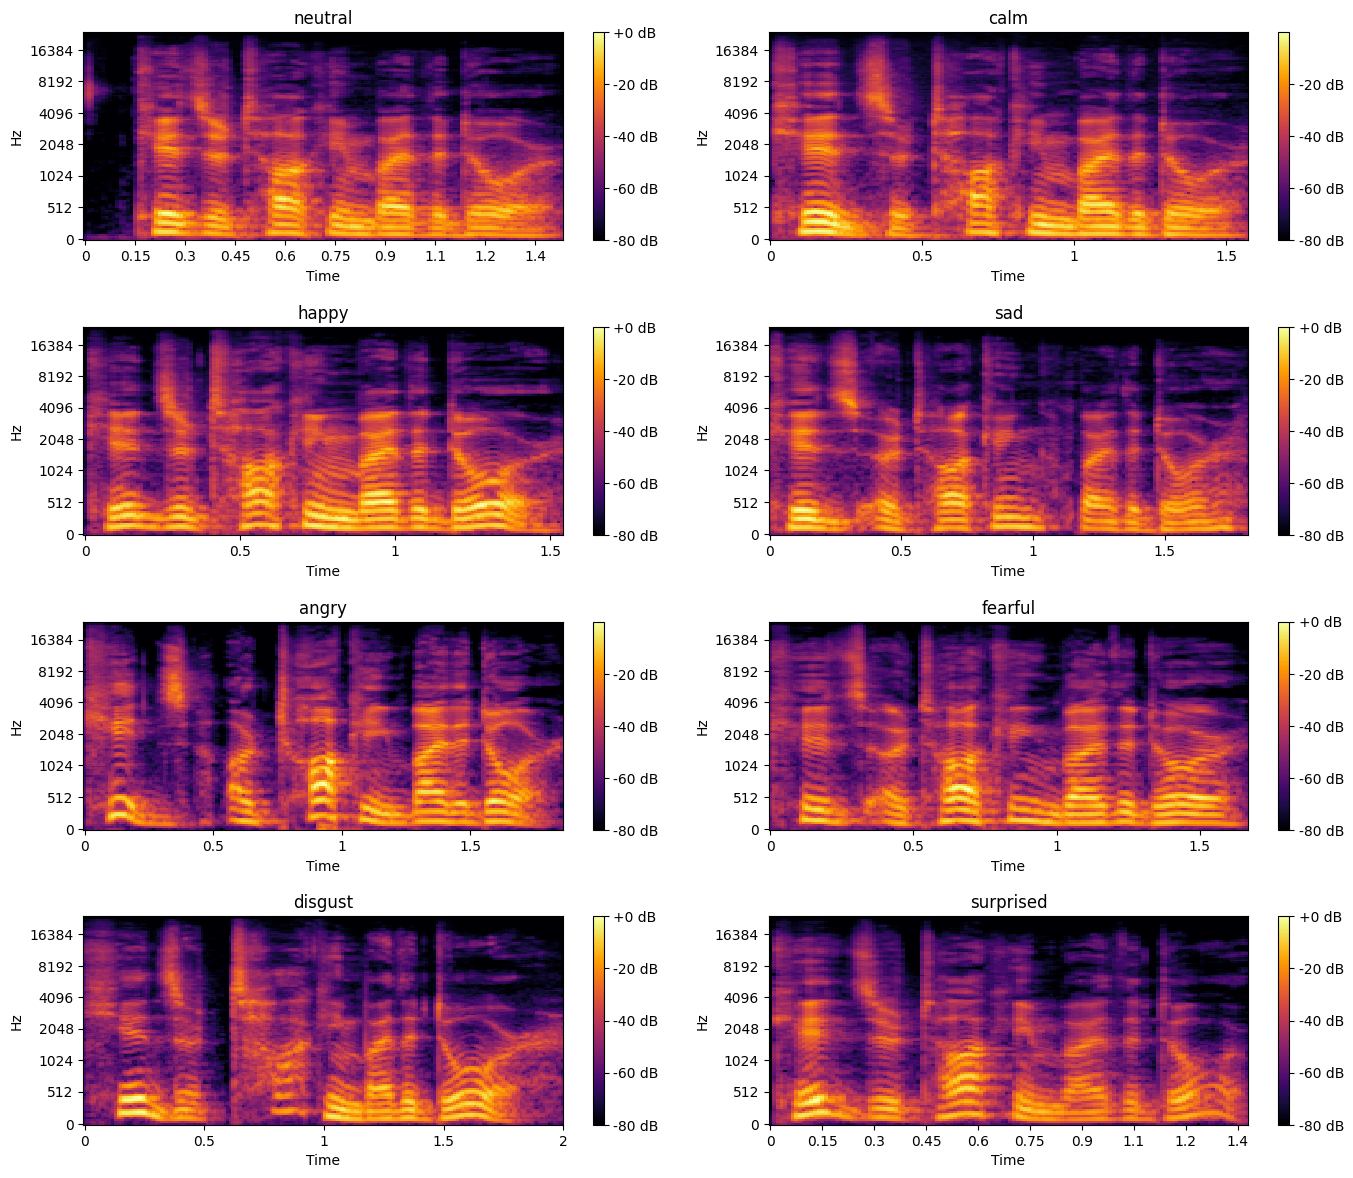

In [ ]:
plt.figure(figsize=(14, 12))
for i in range(1,9):
  audio_path = os.path.join(dpath,f"Actor_01/03-01-0{i}-01-01-01-01.wav")
  y, sr = librosa.load(audio_path,sr=48000)
  ytrim, _ = librosa.effects.trim(y,top_db=30)
  plt.subplot(4,2,i)
  plt.title(labels[f'0{i}'])
  S = librosa.feature.melspectrogram(y=ytrim, sr=sr, n_mels=128)
  S_dB = librosa.power_to_db(S, ref=np.max)
  librosa.display.specshow(S_dB, x_axis='time',y_axis='mel', sr=sr,cmap='inferno')
  plt.colorbar(format='%+2.0f dB')
plt.tight_layout(pad=1.5)
plt.show()

### **Feature Extraction Method 1: MFCC (Mel Frequency Cepstral Coefficients), Chroma, Spectral Contrast & Tonnetz**

In [ ]:
audio_path = os.path.join(dpath,"Actor_01/03-01-03-01-01-01-01.wav")
y, sr = librosa.load(audio_path,sr=48000)
ytrim, _ = librosa.effects.trim(y,top_db=30)
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
print("MFCCs:", mfccs.shape)

chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
print("Chroma STFT:", chroma_stft.shape)

spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
print("Spectral Contrast:", spectral_contrast.shape)

tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)
print("Tonnetz:", tonnetz.shape)

melspec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
print("Mel Spectrogram:", melspec.shape)

MFCCs: (20, 326)
Chroma STFT: (12, 326)
Spectral Contrast: (7, 326)
Tonnetz: (6, 326)
Mel Spectrogram: (128, 326)


In [ ]:
melspec.mean(axis=1)[:5]

array([2.2461840e-05, 3.1568366e-04, 1.0257526e-02, 7.0310988e-02,
       1.1597534e-01], dtype=float32)

In [ ]:
mfccs.mean(axis=1)

array([-645.9547   ,   63.116707 ,   -4.388943 ,   12.588354 ,
          4.2411594,   -2.9022615,   -5.671873 ,   -6.6233635,
        -11.532384 ,   -2.3804133,   -1.2910134,   -6.8026524,
          1.1827934,   -4.6723757,   -2.413551 ,    2.1658797,
         -8.006255 ,   -2.8629193,   -2.44791  ,   -2.5724356],
      dtype=float32)

In [ ]:
def extract_features(audio, sr):
    features = {}
    audio, _ = librosa.effects.trim(audio,top_db=30)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20).mean(axis=1)
    for i, value in enumerate(mfcc):
        features[f'mfcc{i+1}'] = value

    chroma = librosa.feature.chroma_stft(y=audio, sr=sr).mean(axis=1)
    for i, value in enumerate(chroma):
        features[f'chroma{i+1}'] = value

    spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sr).mean(axis=1)
    for i, value in enumerate(spectral_contrast):
        features[f'spectral_contrast{i+1}'] = value

    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(audio), sr=sr).mean(axis=1)
    for i, value in enumerate(tonnetz):
        features[f'tonnetz{i+1}'] = value
    return features

In [ ]:
import warnings,tqdm
warnings.filterwarnings('ignore')
root_dir = '/content/drive/MyDrive/PBL_2_Files/SpeechData'
feats = []
for actor_dir in tqdm.tqdm(os.listdir(root_dir)):
  actor_path = os.path.join(root_dir, actor_dir)
  for audio_file in os.listdir(actor_path):
    label = labels[audio_file[6:8]]
    audio_path = os.path.join(actor_path, audio_file)
    y, sr = librosa.load(audio_path)
    feat = extract_features(audio=y,sr=sr)
    feat['label'] = label
    feats.append(feat)
df = pd.DataFrame(feats)
df

100%|██████████| 24/24 [23:59<00:00, 59.97s/it]


mfcc1       mfcc2      mfcc3      mfcc4      mfcc5      mfcc6  \
0    -485.435760  125.547394  -9.674951  24.648426  14.435010  -5.135542   
1    -482.768646  116.302711  -7.825341  29.099022  13.977194  -7.079821   
2    -473.852509  124.038834  -6.438733  27.357559   6.484828  -2.441446   
3    -471.156219  114.611885  -0.160490  28.123051   9.483887   0.481434   
4    -537.455322  115.149666  -0.266134  27.281796  11.806399  -0.392792   
...          ...         ...        ...        ...        ...        ...   
1435 -388.423798   49.331264 -34.764870  -9.011050 -32.060207 -17.719212   
1436 -359.528259   71.705933 -24.668306 -15.782925 -27.563425 -24.489244   
1437 -362.508392   57.615002 -30.649122 -11.101861 -25.432745 -29.665735   
1438 -335.579681   33.132145 -12.196454  -0.531582 -22.737276 -10.965969   
1439 -361.271973   52.356255  -4.962587 -12.411792 -11.750564 -14.138453   

          mfcc7      mfcc8      mfcc9     mfcc10  ...  spectral_contrast5  \
0     -9.597647 -12.427289 -28.499628  -9.909325  ...           17.556507   
1     -8.166739 -14.216777 -28.183737  -6.398925  ...           17.641812   
2     -8.439913 -14.846802 -25.888828 -10.471825  ...           17.605386   
3     -8.060111 -17.652519 -24.048738  -8.849403  ...           17.496499   
4    -10.151818  -9.871162 -21.435678 -11.071154  ...           18.493990   
...         ...        ...        ...        ...  ...                 ...   
1435 -29.563887 -29.137506 -13.860537 -14.604786  ...           21.742607   
1436 -19.819939 -21.724846 -16.119669  -7.874968  ...           19.135184   
1437 -21.715458 -21.400555 -13.992214  -1.879903  ...           19.038516   
1438 -17.820589 -14.762376  -4.650029 -11.590913  ...           18.778600   
1439 -20.575493 -11.487005 -20.562305  -7.169571  ...           18.699686   

      spectral_contrast6  spectral_contrast7  tonnetz1  tonnetz2  tonnetz3  \
0              21.315920           46.004490 -0.014624  0.009249 -0.104367   
1              21.521437           44.981970 -0.054861  0.013295 -0.143152   
2              21.148907           44.513486 -0.030163  0.007646 -0.065461   
3              19.287395           43.730201 -0.067261  0.035002 -0.045678   
4              19.873453           44.811323 -0.057544  0.001106 -0.000953   
...                  ...                 ...       ...       ...       ...   
1435           20.309285           43.784330  0.015853  0.004768  0.001270   
1436           20.070731           45.208090 -0.056758  0.029068  0.037088   
1437           21.141644           45.690610 -0.049266  0.035268 -0.075087   
1438           18.536483           43.943840 -0.045750  0.029859 -0.047508   
1439           18.319511           45.462155 -0.065888  0.085322 -0.006442   

      tonnetz4  tonnetz5  tonnetz6      label  
0     0.010106  0.001155  0.028047    neutral  
1    -0.022336  0.016985 -0.010868    neutral  
2     0.140499 -0.003934  0.048810    neutral  
3     0.056660  0.004700  0.032460    neutral  
4    -0.094754  0.010267 -0.001635       calm  
...        ...       ...       ...        ...  
1435  0.090348  0.021537  0.047590  surprised  
1436  0.051136  0.014402  0.021878  surprised  
1437  0.004266  0.005730  0.011209  surprised  
1438 -0.057710  0.003721 -0.007773  surprised  
1439 -0.030386 -0.004984  0.011510  surprised  

[1440 rows x 46 columns]

In [ ]:
df.to_csv('/content/drive/MyDrive/PBL_2_Files/features2.csv',index=False)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/PBL_2_Files/features.csv')

In [ ]:
df['label'].value_counts()

label
calm         192
happy        192
sad          192
angry        192
fearful      192
disgust      192
surprised    192
neutral       96
Name: count, dtype: int64

In [ ]:
xmfcc = df.iloc[:,:20]
xchr = df.iloc[:,20:32]
xspc = df.iloc[:,32:39]
xton = df.iloc[:,39:-1]
xall = df.drop('label',axis=1)
y = df['label']

### **Training & Testing ML Models on above features**

In [ ]:
from sklearn.preprocessing import StandardScaler
def scale_n_split(feat,y):
    scaler = StandardScaler()
    x = scaler.fit_transform(feat)
    trainX, testX, trainY, testY = train_test_split(x, y, test_size=0.2, random_state=536,stratify=y)
    return trainX, testX, trainY, testY
def traintestmodel(feat,y,title,rs=42,printany=True):
    trainX, testX, trainY, testY = scale_n_split(feat,y)
    lr_model = LogisticRegression(random_state=rs)
    lr_model.fit(trainX, trainY)
    lr_predictions = lr_model.predict(testX)
    acc_lr = accuracy_score(testY, lr_predictions)
    if printany:
      print(f"Logistic Regression Accuracy: {acc_lr*100:.3f}%")
      print(classification_report(testY, lr_predictions))

    dt_model = DecisionTreeClassifier(random_state=rs)
    dt_model.fit(trainX, trainY)
    dt_predictions = dt_model.predict(testX)
    acc_dt = accuracy_score(testY, dt_predictions)
    if printany:
      print(f"Decision Tree Accuracy: {acc_dt*100:.3f}%")
      print(classification_report(testY, dt_predictions))

    rf_model = RandomForestClassifier(n_estimators=400,random_state=rs)
    rf_model.fit(trainX, trainY)
    rf_predictions = rf_model.predict(testX)
    acc_rf = accuracy_score(testY, rf_predictions)
    if printany:
      print(f"Random Forest Accuracy: {acc_rf*100:.3f}%")
      print(classification_report(testY, rf_predictions))

    svm_model = SVC(random_state=rs)
    svm_model.fit(trainX, trainY)
    svm_predictions = svm_model.predict(testX)
    acc_svm = accuracy_score(testY, svm_predictions)
    if printany:
      print(f"SVM Accuracy: {acc_svm*100:.3f}%")
      print(classification_report(testY, svm_predictions))

    knn_model = KNeighborsClassifier()
    knn_model.fit(trainX, trainY)
    knn_predictions = knn_model.predict(testX)
    acc_knn = accuracy_score(testY, knn_predictions)
    if printany:
      print(f"KNN Accuracy: {acc_knn*100:.3f}%")
      print(classification_report(testY, knn_predictions))

    models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM', 'KNN']
    accuracies = [acc_lr, acc_dt, acc_rf, acc_svm, acc_knn]
    if printany:
      plt.figure(figsize=(8, 4))
      bars = plt.bar(models, accuracies)
      for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, f'{height*100:.2f}%', ha='center', va='bottom')
      plt.title(f'Accuracy Comparison of Different Models using {title} features')
      plt.xlabel('Models')
      plt.ylabel('Accuracy')
      plt.ylim(0, 1)
      plt.show()
    return dict(zip(models,accuracies))

Logistic Regression Accuracy: 55.903%
              precision    recall  f1-score   support

       angry       0.65      0.63      0.64        38
        calm       0.63      0.58      0.60        38
     disgust       0.50      0.62      0.55        39
     fearful       0.54      0.53      0.53        38
       happy       0.59      0.56      0.58        39
     neutral       0.38      0.32      0.34        19
         sad       0.48      0.54      0.51        39
   surprised       0.65      0.58      0.61        38

    accuracy                           0.56       288
   macro avg       0.55      0.54      0.55       288
weighted avg       0.56      0.56      0.56       288

Decision Tree Accuracy: 41.319%
              precision    recall  f1-score   support

       angry       0.47      0.47      0.47        38
        calm       0.54      0.53      0.53        38
     disgust       0.52      0.41      0.46        39
     fearful       0.46      0.32      0.38        38
       h

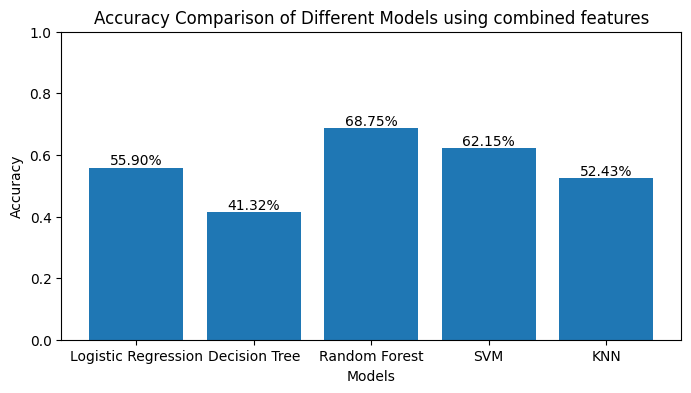

In [ ]:
acc_dict = traintestmodel(xall,y,'combined')

Logistic Regression Accuracy: 46.875%
              precision    recall  f1-score   support

       angry       0.60      0.66      0.62        38
        calm       0.49      0.55      0.52        38
     disgust       0.46      0.41      0.43        39
     fearful       0.48      0.42      0.45        38
       happy       0.48      0.56      0.52        39
     neutral       0.18      0.16      0.17        19
         sad       0.41      0.44      0.42        39
   surprised       0.48      0.39      0.43        38

    accuracy                           0.47       288
   macro avg       0.45      0.45      0.45       288
weighted avg       0.47      0.47      0.46       288

Decision Tree Accuracy: 39.583%
              precision    recall  f1-score   support

       angry       0.58      0.50      0.54        38
        calm       0.50      0.47      0.49        38
     disgust       0.32      0.23      0.27        39
     fearful       0.25      0.21      0.23        38
       h

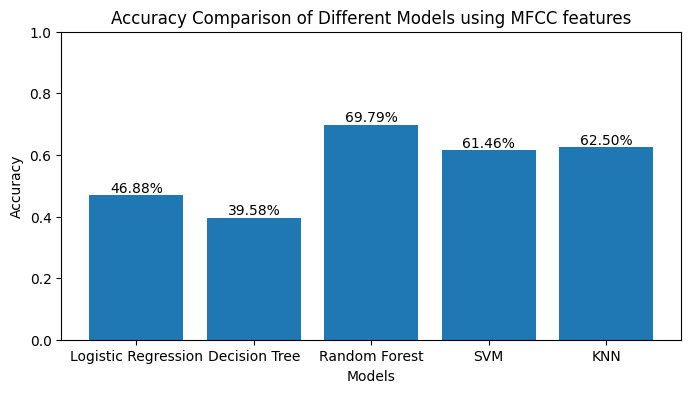

In [ ]:
acc_mfcc = traintestmodel(xmfcc,y,'MFCC')

Logistic Regression Accuracy: 26.389%
              precision    recall  f1-score   support

       angry       0.36      0.13      0.19        38
        calm       0.25      0.45      0.32        38
     disgust       0.37      0.28      0.32        39
     fearful       0.30      0.32      0.31        38
       happy       0.30      0.28      0.29        39
     neutral       0.22      0.11      0.14        19
         sad       0.20      0.26      0.22        39
   surprised       0.20      0.21      0.21        38

    accuracy                           0.26       288
   macro avg       0.27      0.25      0.25       288
weighted avg       0.28      0.26      0.26       288

Decision Tree Accuracy: 19.792%
              precision    recall  f1-score   support

       angry       0.14      0.18      0.16        38
        calm       0.21      0.21      0.21        38
     disgust       0.23      0.23      0.23        39
     fearful       0.27      0.26      0.27        38
       h

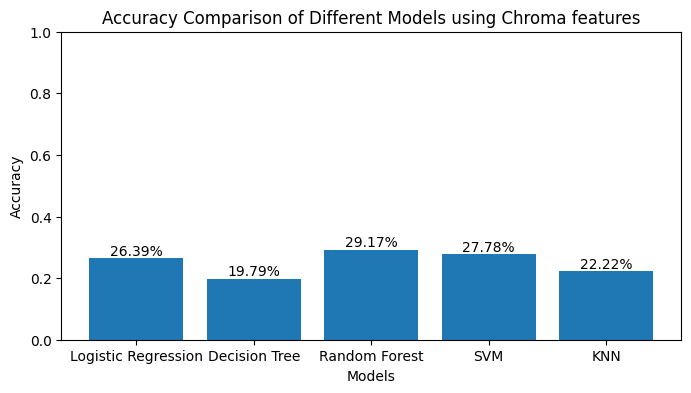

In [ ]:
acc_chr = traintestmodel(xchr,y,'Chroma')

Logistic Regression Accuracy: 27.431%
              precision    recall  f1-score   support

       angry       0.31      0.29      0.30        38
        calm       0.33      0.45      0.38        38
     disgust       0.24      0.28      0.26        39
     fearful       0.15      0.13      0.14        38
       happy       0.29      0.33      0.31        39
     neutral       0.20      0.16      0.18        19
         sad       0.13      0.05      0.07        39
   surprised       0.36      0.45      0.40        38

    accuracy                           0.27       288
   macro avg       0.25      0.27      0.25       288
weighted avg       0.26      0.27      0.26       288

Decision Tree Accuracy: 27.431%
              precision    recall  f1-score   support

       angry       0.41      0.32      0.36        38
        calm       0.28      0.29      0.28        38
     disgust       0.20      0.21      0.20        39
     fearful       0.38      0.29      0.33        38
       h

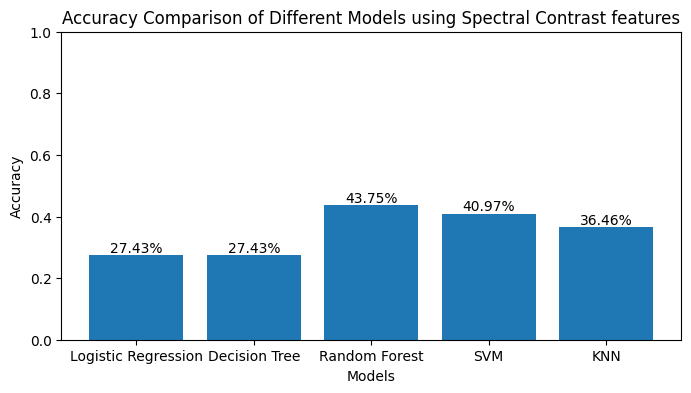

In [ ]:
acc_spc = traintestmodel(xspc,y,'Spectral Contrast')

Logistic Regression Accuracy: 17.361%
              precision    recall  f1-score   support

       angry       0.31      0.11      0.16        38
        calm       0.21      0.39      0.27        38
     disgust       0.12      0.15      0.14        39
     fearful       0.07      0.11      0.09        38
       happy       0.15      0.05      0.08        39
     neutral       1.00      0.05      0.10        19
         sad       0.29      0.13      0.18        39
   surprised       0.19      0.34      0.25        38

    accuracy                           0.17       288
   macro avg       0.29      0.17      0.16       288
weighted avg       0.25      0.17      0.16       288

Decision Tree Accuracy: 18.750%
              precision    recall  f1-score   support

       angry       0.28      0.21      0.24        38
        calm       0.22      0.26      0.24        38
     disgust       0.14      0.15      0.15        39
     fearful       0.16      0.16      0.16        38
       h

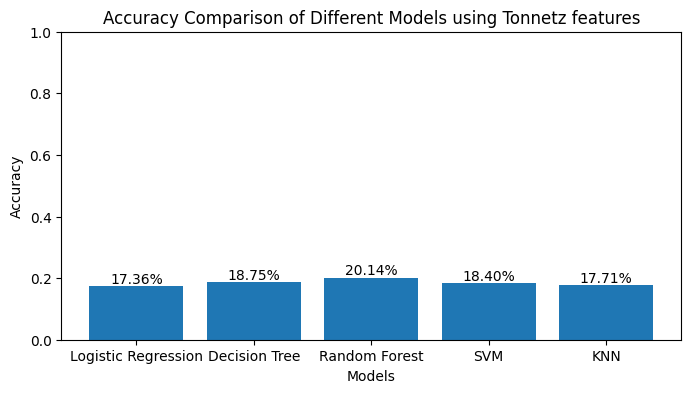

In [ ]:
acc_ton = traintestmodel(xton,y,'Tonnetz')

Logistic Regression Accuracy: 52.778%
              precision    recall  f1-score   support

       angry       0.74      0.61      0.67        38
        calm       0.58      0.55      0.57        38
     disgust       0.42      0.54      0.47        39
     fearful       0.52      0.45      0.48        38
       happy       0.50      0.54      0.52        39
     neutral       0.35      0.32      0.33        19
         sad       0.47      0.44      0.45        39
   surprised       0.60      0.68      0.64        38

    accuracy                           0.53       288
   macro avg       0.52      0.51      0.52       288
weighted avg       0.53      0.53      0.53       288

Decision Tree Accuracy: 42.708%
              precision    recall  f1-score   support

       angry       0.47      0.37      0.41        38
        calm       0.56      0.58      0.57        38
     disgust       0.44      0.44      0.44        39
     fearful       0.48      0.39      0.43        38
       h

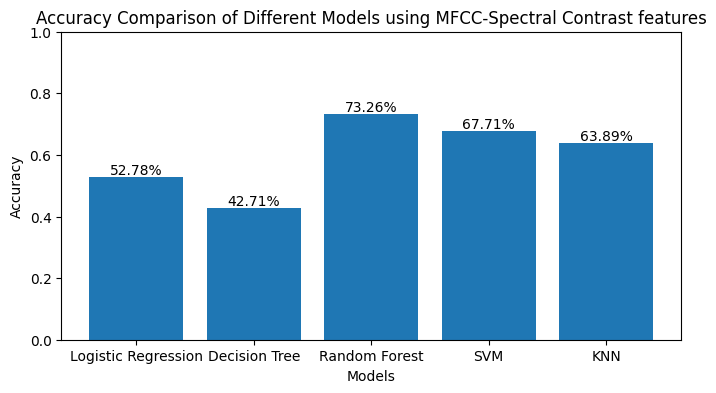

In [ ]:
xmfccspc = df.iloc[:,[i for i in range(20)]+[i for i in range(32,39)]]
acc_mfccspc = traintestmodel(xmfccspc,y,'MFCC-Spectral Contrast')

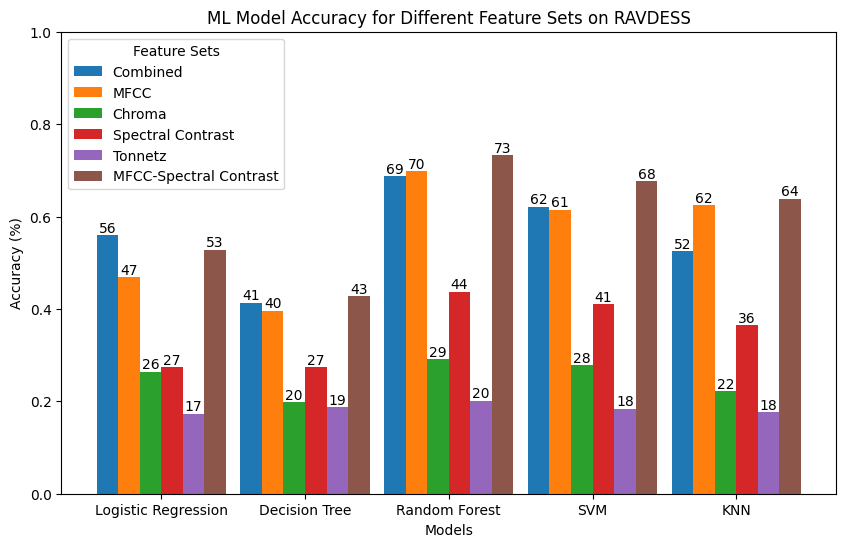

In [ ]:
feat_accs = [acc_dict,acc_mfcc,acc_chr,acc_spc,acc_ton,acc_mfccspc]
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM', 'KNN']
feat_names = ['Combined','MFCC','Chroma','Spectral Contrast','Tonnetz','MFCC-Spectral Contrast']
num_features = len(feat_accs)
num_models = len(models)
x = np.arange(num_models)
bar_width = 0.15
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(num_features):
    bars = ax.bar(x + i * bar_width, feat_accs[i].values(), width=bar_width, label=feat_names[i])
    for bar in bars:
      height = bar.get_height()
      plt.text(bar.get_x() + bar.get_width()/2, height, f'{height*100:.0f}', ha='center', va='bottom')
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy (%)')
ax.set_title('ML Model Accuracy for Different Feature Sets on RAVDESS')
ax.set_xticks(x + bar_width * (num_features - 1) / 2)
ax.set_xticklabels(models)
ax.set_ylim(0,1)
ax.legend(title='Feature Sets')
plt.show()

In [ ]:
maxacc,rs = 0,0
for i in range(451, 601):
  acc_dict = traintestmodel(xall,y,'combined',i,printany=False)
  best_model = max(acc_dict, key=acc_dict.get)
  #print(f"Random State = {i}")
  #print(f"Max Accuracy = {acc_dict[best_model]*100:.2f}% for {best_model}\n")
  if acc_dict[best_model] > maxacc:
    maxacc = acc_dict[best_model]
    rs = i
    print(f"Best Random State = {rs} at accuracy = {maxacc*100:.2f}%")

Best Random State = 451 at accuracy = 67.01%
Best Random State = 453 at accuracy = 68.06%
Best Random State = 459 at accuracy = 69.10%
Best Random State = 513 at accuracy = 69.79%


### **Training ANN Models**

#### Training ANN model without Early Stopping (200 Epochs)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(trainX.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(np.unique(trainY)), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
le = LabelEncoder()
trainY_enc = to_categorical(le.fit_transform(trainY))
testY_enc = to_categorical(le.transform(testY))
#callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
#             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.0001)]
history = model.fit(trainX, trainY_enc, epochs=200, batch_size=32, validation_data=(testX, testY_enc))

_, accuracy = model.evaluate(testX, testY_enc)
print('\nAccuracy: %.2f' % (accuracy*100))

predictions = model.predict(testX)
predicted_labels = le.inverse_transform(np.argmax(predictions, axis=1))

print(classification_report(testY, predicted_labels))


Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1477 - loss: 2.1023 - val_accuracy: 0.2153 - val_loss: 2.0153
Epoch 2/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1973 - loss: 2.0268 - val_accuracy: 0.2778 - val_loss: 1.9438
Epoch 3/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2542 - loss: 1.9396 - val_accuracy: 0.3090 - val_loss: 1.8214
Epoch 4/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2630 - loss: 1.8702 - val_accuracy: 0.3333 - val_loss: 1.7261
Epoch 5/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2751 - loss: 1.8525 - val_accuracy: 0.4514 - val_loss: 1.6603
Epoch 6/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3341 - loss: 1.7241 - val_accuracy: 0.4340 - val_loss: 1.5800
Epoch 7/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3796 - loss: 1.6764 - val_accuracy: 0.4757 - val_loss: 1.5459
Epoch 8/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4104 - loss: 1.5923 - val_accuracy: 0.4826 - val_loss: 1.4

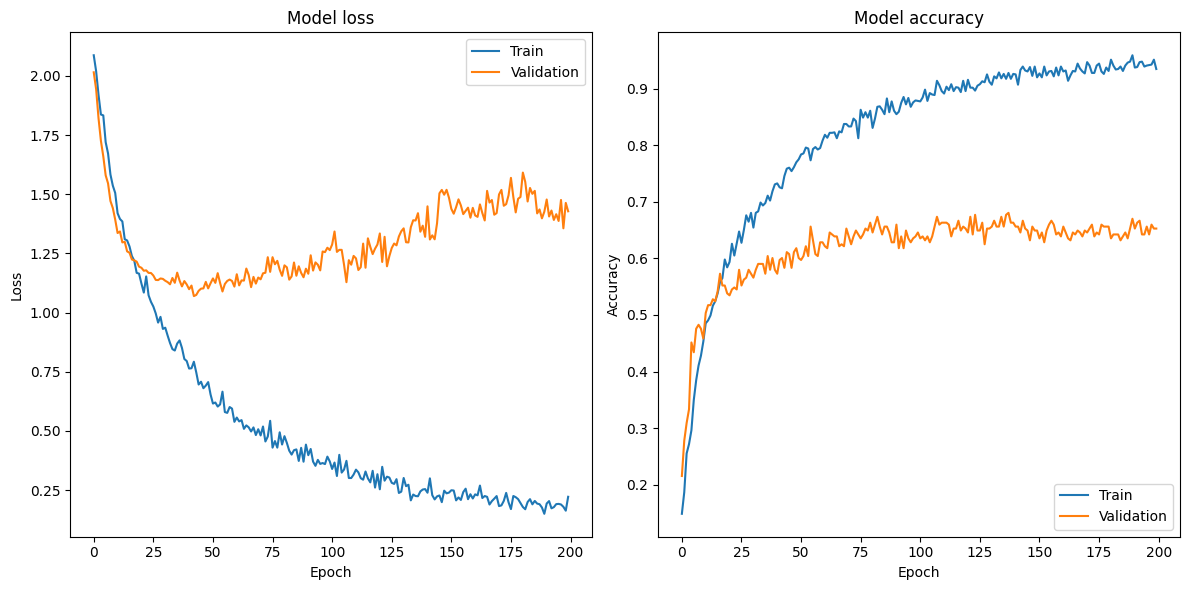

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.show()


#### Applying ANN with Early Stopping and Adaptive Learning Rate Scheduling

In [ ]:
model2 = Sequential()
model2.add(Dense(128, activation='relu', input_shape=(trainX.shape[1],)))
model2.add(Dropout(0.3))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(len(np.unique(trainY)), activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True),
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=15, min_lr=0.0001)]
history2 = model2.fit(trainX, trainY_enc, epochs=500, batch_size=32, validation_data=(testX, testY_enc),callbacks=callbacks)

_, accuracy = model2.evaluate(testX, testY_enc)
print('\nAccuracy: %.2f' % (accuracy*100))

predictions = model2.predict(testX)
predicted_labels = le.inverse_transform(np.argmax(predictions, axis=1))

print(classification_report(testY, predicted_labels))

Epoch 1/500


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1237 - loss: 2.1693 - val_accuracy: 0.1979 - val_loss: 2.0415 - learning_rate: 0.0010
Epoch 2/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1603 - loss: 2.0512 - val_accuracy: 0.2257 - val_loss: 2.0018 - learning_rate: 0.0010
Epoch 3/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2138 - loss: 2.0018 - val_accuracy: 0.3056 - val_loss: 1.9056 - learning_rate: 0.0010
Epoch 4/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2629 - loss: 1.9149 - val_accuracy: 0.3125 - val_loss: 1.7935 - learning_rate: 0.0010
Epoch 5/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2859 - loss: 1.8754 - val_accuracy: 0.3854 - val_loss: 1.6979 - learning_rate: 0.0010
Epoch 6/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3268 - loss: 1.7701 - val_accuracy: 0.3750 - val_loss: 1.6250 - learning_rate: 0.0010
Epoch 7/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3335 - loss: 1.6984 - val_accuracy: 0.420

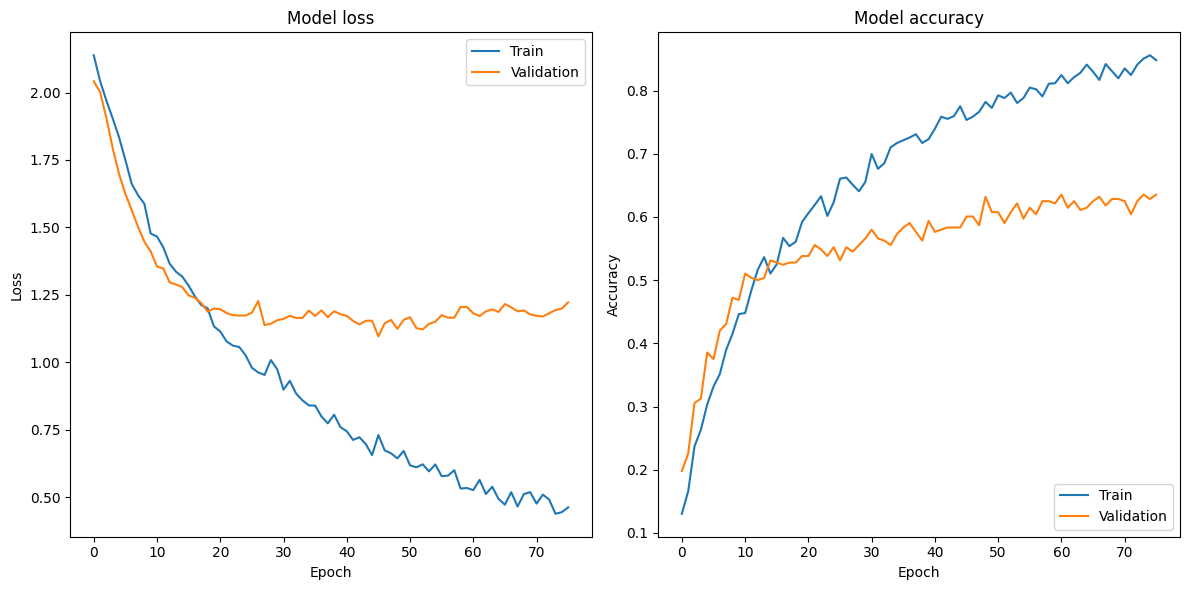

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.show()

### **Feature Extraction Method 2 : Mel-Spectrograms Images**

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
dpath = '/content/drive/MyDrive/PBL_2_Files/SpeechData'
audio_path = os.path.join(dpath,"Actor_01/03-01-05-01-01-01-01.wav")
y, sr = librosa.load(audio_path)
ytrim, _ = librosa.effects.trim(y,top_db=30)
S = librosa.feature.melspectrogram(y=ytrim, sr=sr, n_mels=128)
print(S.shape)
S_dB = librosa.power_to_db(S, ref=np.max)
print(S_dB.shape)
fig = plt.figure(figsize=[0.72,0.72])
ax = fig.add_subplot(111)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_frame_on(False)
librosa.display.specshow(S_dB, x_axis='time',y_axis='mel', sr=sr,cmap='inferno')
filename  = 'temp.jpg'
plt.savefig(filename, dpi = 400, bbox_inches = 'tight',pad_inches = 0)
plt.close()
image = tf.io.read_file(filename)
import cv2
image = tf.image.decode_jpeg(image, channels=3)
#image = tf.image.resize(image,(256,256),method=tf.image.ResizeMethod.BILINEAR)
image = cv2.resize(image.numpy(),(256,256))
os.remove(filename)

(128, 82)
(128, 82)


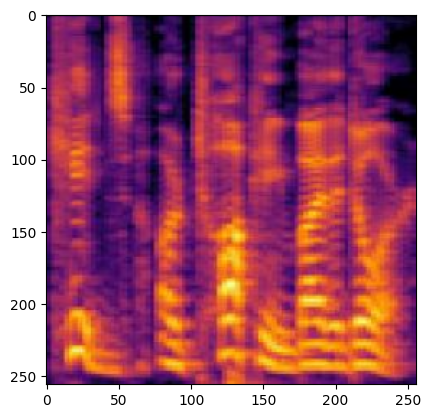

In [ ]:
plt.imshow(image)

22050
(128, 64)
(128, 64)


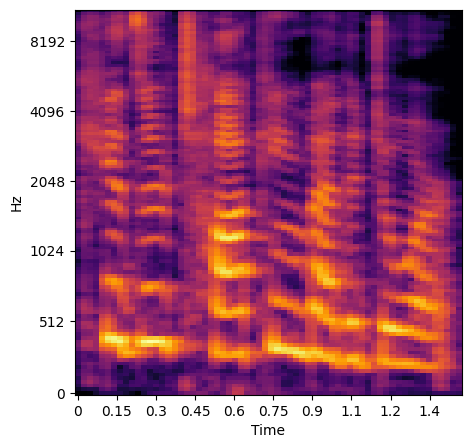

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
dpath = '/content/drive/MyDrive/PBL_2_Files/SpeechData/Actor_04'
wavs = os.listdir(dpath)
wav = np.random.choice(wavs)
audio_path = os.path.join(dpath,wav)
y, sr = librosa.load(audio_path,sr)
print(sr)
ytrim, _ = librosa.effects.trim(y,top_db=30)
S = librosa.feature.melspectrogram(y=ytrim, sr=sr, n_mels=128)
print(S.shape)
S_dB = librosa.power_to_db(S, ref=np.max)
print(S_dB.shape)
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
#ax.axes.get_xaxis().set_visible(False)
#ax.axes.get_yaxis().set_visible(False)
#ax.set_frame_on(False)
librosa.display.specshow(S_dB, x_axis='time',y_axis='mel', sr=sr,cmap='inferno')

In [ ]:
np.array(image).shape

(256, 256, 3)

In [ ]:
import tqdm
import tensorflow as tf
specs = []
labelss = []
root_dir = '/content/drive/MyDrive/PBL_2_Files/SpeechData'
labels = { '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad', '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised' }
for actor_dir in tqdm.tqdm(os.listdir(root_dir)):
    actor_path = os.path.join(root_dir, actor_dir)
    for audio_file in os.listdir(actor_path):
        #print(audio_file)
        label = labels[audio_file[6:8]]
        audio_path = os.path.join(actor_path, audio_file)
        y, sr = librosa.load(audio_path)
        ytrim, _ = librosa.effects.trim(y, top_db=30)
        S = librosa.feature.melspectrogram(y=ytrim, sr=sr, n_mels=128)
        S_dB = librosa.power_to_db(S, ref=np.max)
        fig = plt.figure(figsize=[0.72,0.72])
        ax = fig.add_subplot(111)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.set_frame_on(False)
        librosa.display.specshow(S_dB, x_axis='time',y_axis='mel', sr=sr,cmap='inferno')
        filename  = 'temp.jpg'
        plt.savefig(filename, dpi = 400, bbox_inches = 'tight',pad_inches = 0)
        plt.close()
        image = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image, channels=3)
        image = cv2.resize(image.numpy(),(256,256))
        os.remove(filename)
        specs.append(image)
        labelss.append(label)
specs = np.array(specs)
labelss = np.array(labelss)

100%|██████████| 24/24 [21:27<00:00, 53.65s/it]


In [ ]:
specsnlabs = specs,labelss
with open('/content/drive/MyDrive/PBL_2_Files/specsnlabs.pkl', 'wb') as f:
    pickle.dump(specsnlabs, f)

In [ ]:
with open('/content/drive/MyDrive/PBL_2_Files/specsnlabs.pkl', 'rb') as f:
    specs, labelss = pickle.load(f)

In [ ]:
specs.shape

(1440, 256, 256, 3)

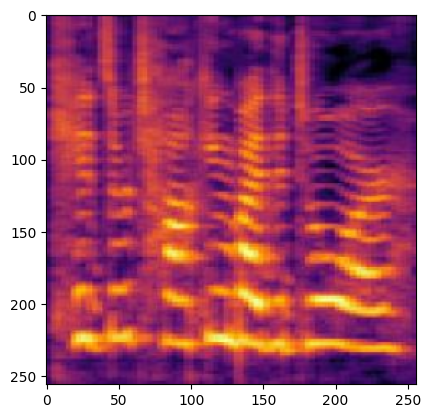

In [ ]:
plt.imshow(specs[96])

### **Training CNN models on Mel-spectrograms**

#### Uniform Filter Sizes (3x3)

In [ ]:
X = np.expand_dims(specs, axis=-1)
le = LabelEncoder()
y_enc = to_categorical(le.fit_transform(labelss))

X_train, X_test, y_train, y_test = train_test_split(specs, y_enc, test_size=0.2, random_state=42)

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(np.unique(labelss)), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
mpath = '/content/drive/MyDrive/PBL_2_Files/Models/best_cnn_model.keras'
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True),
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=15, min_lr=0.0001),
             tf.keras.callbacks.ModelCheckpoint(filepath=mpath, monitor='val_loss', save_best_only=True,verbose=1)]
histcnn = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_test, y_test),callbacks=callbacks)

_, accuracy = model.evaluate(X_test, y_test)
print('\nAccuracy: %.2f' % (accuracy*100))

Epoch 1/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.1538 - loss: 2.0585
Epoch 1: val_loss improved from inf to 6.45419, saving model to /content/drive/MyDrive/PBL_2_Files/Models/best_cnn_model.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 203ms/step - accuracy: 0.1546 - loss: 2.0578 - val_accuracy: 0.1111 - val_loss: 6.4542 - learning_rate: 0.0010
Epoch 2/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.2497 - loss: 1.9763
Epoch 2: val_loss improved from 6.45419 to 6.08546, saving model to /content/drive/MyDrive/PBL_2_Files/Models/best_cnn_model.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 0.2494 - loss: 1.9760 - val_accuracy: 0.1111 - val_loss: 6.0855 - learning_rate: 0.0010
Epoch 3/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.2535 - loss: 1.9166
Epoch 3: val_loss improved from 6.08546 to 3.14884, saving model to /content/drive/MyDrive/PBL_2_Files/Models/best_cnn_model.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step - accuracy: 0.2536 - loss:

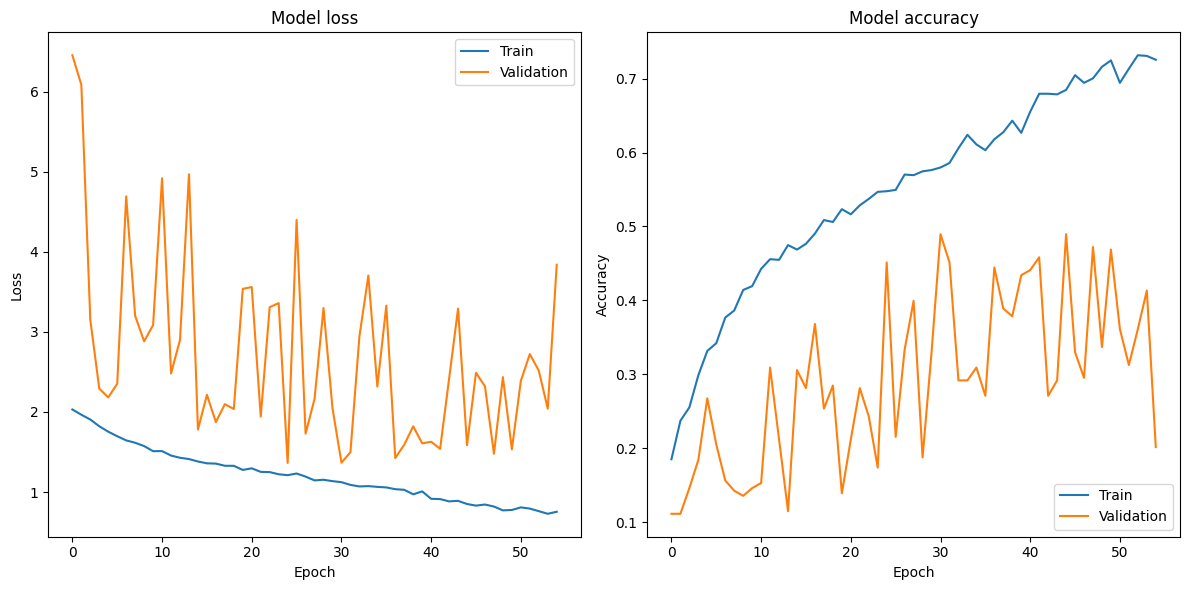

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(histcnn.history['loss'])
plt.plot(histcnn.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(histcnn.history['accuracy'])
plt.plot(histcnn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.show()

#### Different Filter Sizes

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Conv2D(128, (7, 7), activation='relu'))
model.add(Conv2D(128, (7, 7), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(np.unique(labelss)), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 252, 252, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 126, 126, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 126, 126, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 122, 122, 64)        │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 118, 118, 64)        │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 59, 59, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 59, 59, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 59, 59, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 53, 53, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 47, 47, 128)         │         802,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 23, 23, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 23, 23, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 23, 23, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,374,696 (5.24 MB)

 Trainable params: 1,374,248 (5.24 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
mpath = '/content/drive/MyDrive/PBL_2_Files/Models/best_cnn_model.keras'
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True),
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=15, min_lr=0.0001),
             tf.keras.callbacks.ModelCheckpoint(filepath=mpath, monitor='val_loss', save_best_only=True,verbose=1)]
histcnn2 = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_test, y_test),callbacks=callbacks)

_, accuracy = model.evaluate(X_test, y_test)
print(f'\nAccuracy: {accuracy*100:.2f}%')

Epoch 1/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.1729 - loss: 2.0707
Epoch 1: val_loss improved from inf to 12.91725, saving model to /content/drive/MyDrive/PBL_2_Files/Models/best_cnn_model.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 39s 386ms/step - accuracy: 0.1734 - loss: 2.0697 - val_accuracy: 0.1111 - val_loss: 12.9173 - learning_rate: 0.0010
Epoch 2/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.2696 - loss: 1.9205
Epoch 2: val_loss improved from 12.91725 to 10.78666, saving model to /content/drive/MyDrive/PBL_2_Files/Models/best_cnn_model.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 251ms/step - accuracy: 0.2697 - loss: 1.9200 - val_accuracy: 0.1562 - val_loss: 10.7867 - learning_rate: 0.0010
Epoch 3/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.3051 - loss: 1.8604
Epoch 3: val_loss improved from 10.78666 to 5.37723, saving model to /content/drive/MyDrive/PBL_2_Files/Models/best_cnn_model.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 242ms/step - accuracy: 0.3051 

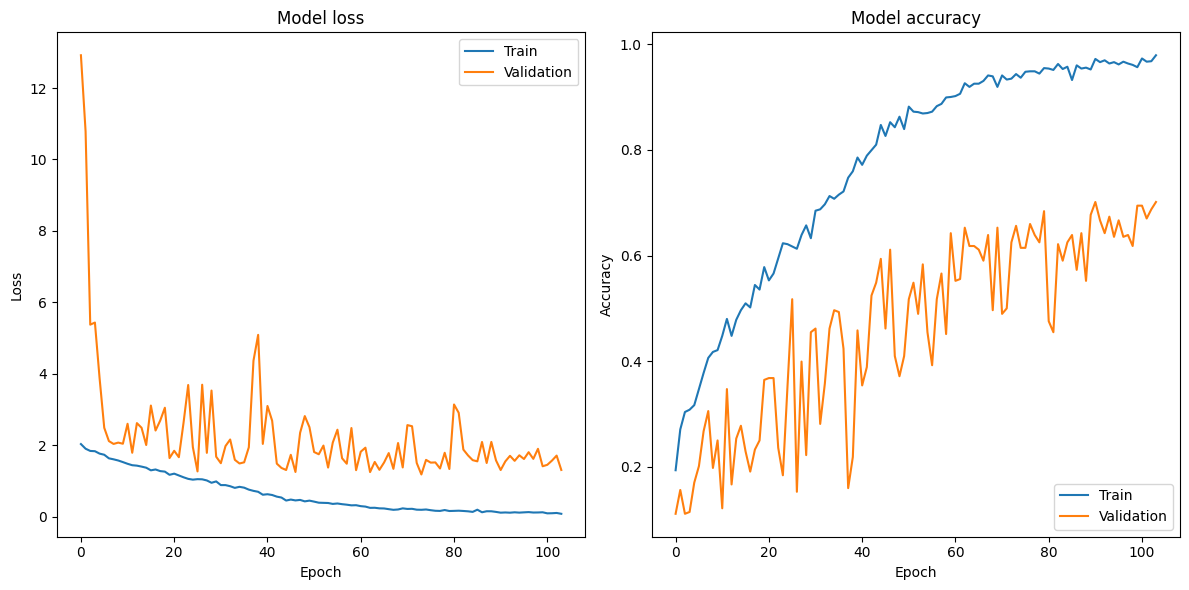

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(histcnn2.history['loss'])
plt.plot(histcnn2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(histcnn2.history['accuracy'])
plt.plot(histcnn2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.show()

#### Training a CNN model using 5-Fold Cross Validation

In [ ]:
def create_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256,256,3)))
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256,256,3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(64, (5, 5), activation='relu'))
  model.add(Conv2D(64, (5, 5), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(128, (7, 7), activation='relu'))
  model.add(Conv2D(128, (7, 7), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(GlobalAveragePooling2D())
  model.add(Dense(32, activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(len(np.unique(labelss)), activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model


Training fold 1...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.1754 - loss: 2.0469
Epoch 1: val_accuracy improved from -inf to 0.13889, saving model to /content/drive/MyDrive/PBL_2_Files/Models/best_cnn_model_fold1.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 49s 497ms/step - accuracy: 0.1758 - loss: 2.0465 - val_accuracy: 0.1389 - val_loss: 15.7754 - learning_rate: 0.0010
Epoch 2/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.1950 - loss: 1.9902
Epoch 2: val_accuracy improved from 0.13889 to 0.20486, saving model to /content/drive/MyDrive/PBL_2_Files/Models/best_cnn_model_fold1.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 45s 241ms/step - accuracy: 0.1955 - loss: 1.9899 - val_accuracy: 0.2049 - val_loss: 2.8022 - learning_rate: 0.0010
Epoch 3/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.2828 - loss: 1.9136
Epoch 3: val_accuracy did not improve from 0.20486
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 229ms/step - accuracy: 0.2827 - loss: 1.9133 - val_accuracy: 0.1250 - val_loss: 8.1224 - lear

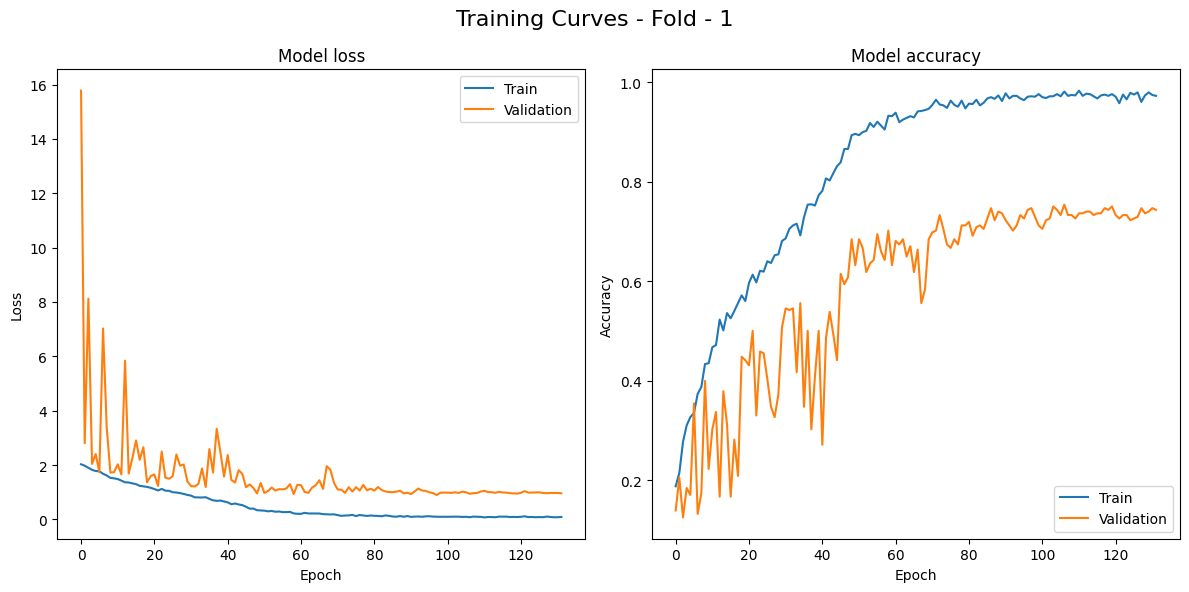

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


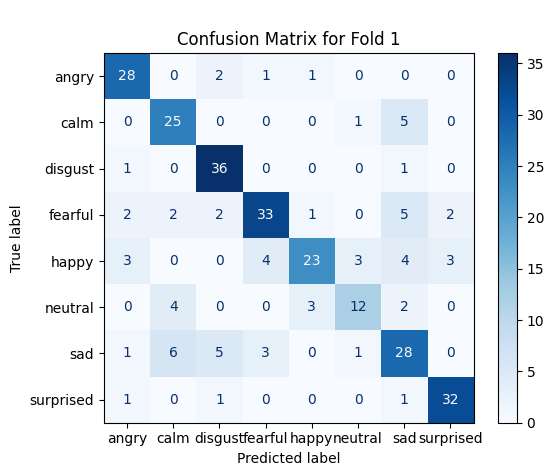


Fold 1 Validation Accuracy: 75.3472%

Training fold 2...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.1379 - loss: 2.0947
Epoch 1: val_accuracy improved from -inf to 0.15278, saving model to /content/drive/MyDrive/PBL_2_Files/Models/best_cnn_model_fold2.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 343ms/step - accuracy: 0.1383 - loss: 2.0938 - val_accuracy: 0.1528 - val_loss: 16.7204 - learning_rate: 0.0010
Epoch 2/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.2168 - loss: 1.9719
Epoch 2: val_accuracy did not improve from 0.15278
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 238ms/step - accuracy: 0.2174 - loss: 1.9717 - val_accuracy: 0.1528 - val_loss: 12.0269 - learning_rate: 0.0010
Epoch 3/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.2484 - loss: 1.9036
Epoch 3: val_accuracy improved from 0.15278 to 0.20486, saving model to /content/drive/MyDrive/PBL_2_Files/Models/best_cnn_model_fold2.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 248ms/step - accuracy: 0.2488 - loss: 1.9027 - val_accuracy: 0.2049 - val_loss: 2.4449 - lea

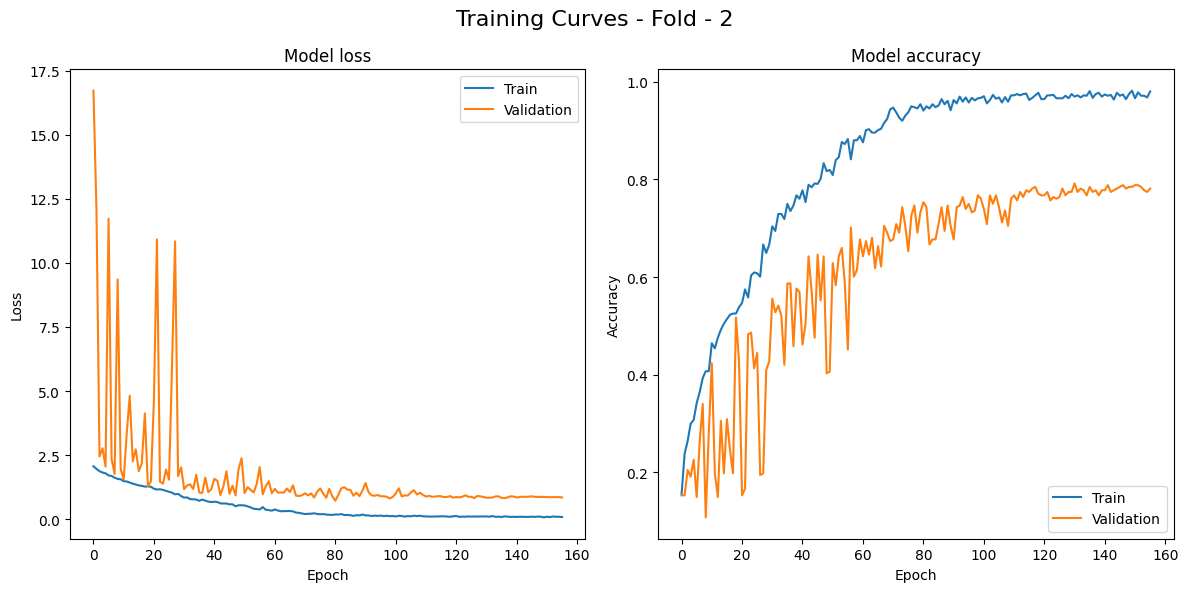

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


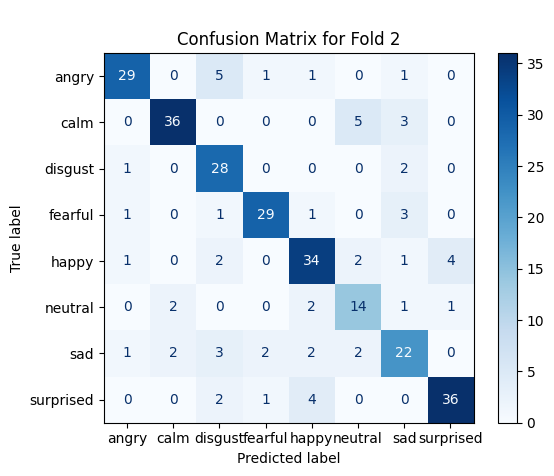


Fold 2 Validation Accuracy: 79.1667%

Training fold 3...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.1593 - loss: 2.0654
Epoch 1: val_accuracy improved from -inf to 0.14583, saving model to /content/drive/MyDrive/PBL_2_Files/Models/best_cnn_model_fold3.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 338ms/step - accuracy: 0.1602 - loss: 2.0644 - val_accuracy: 0.1458 - val_loss: 17.4214 - learning_rate: 0.0010
Epoch 2/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.2816 - loss: 1.9171
Epoch 2: val_accuracy did not improve from 0.14583
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 244ms/step - accuracy: 0.2815 - loss: 1.9170 - val_accuracy: 0.1354 - val_loss: 3.8986 - learning_rate: 0.0010
Epoch 3/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.2803 - loss: 1.8484
Epoch 3: val_accuracy improved from 0.14583 to 0.21528, saving model to /content/drive/MyDrive/PBL_2_Files/Models/best_cnn_model_fold3.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 256ms/step - accuracy: 0.2801 - loss: 1.8482 - val_accuracy: 0.2153 - val_loss: 2.9094 - lear

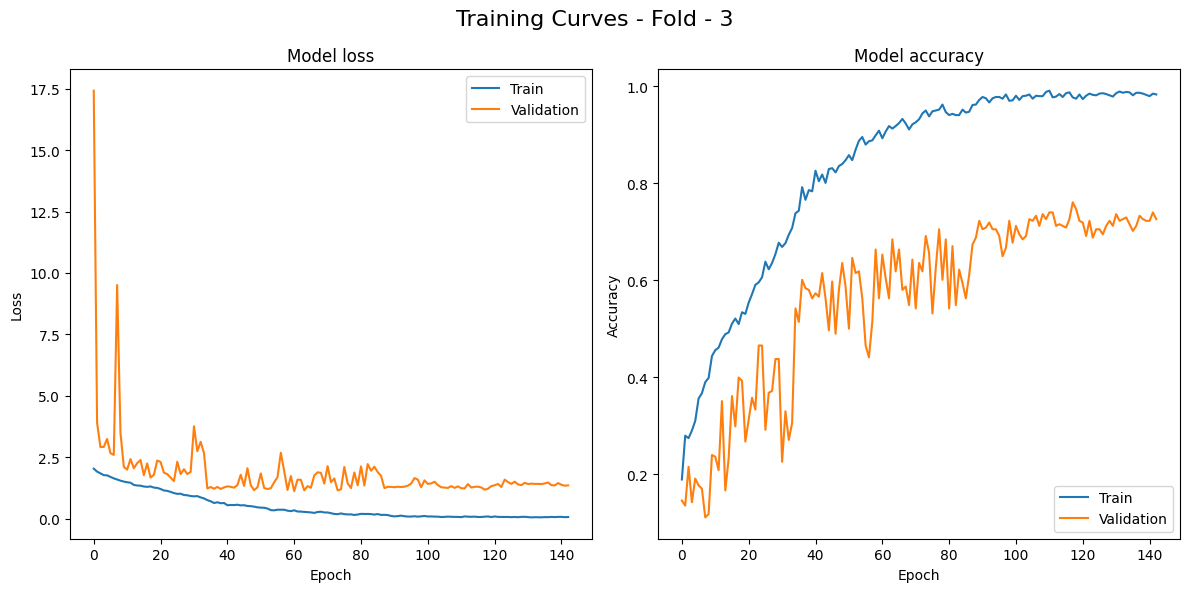

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


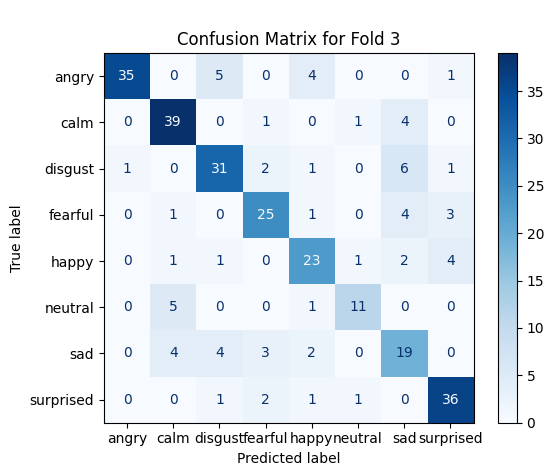


Fold 3 Validation Accuracy: 76.0417%

Training fold 4...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.2079 - loss: 2.0756
Epoch 1: val_accuracy improved from -inf to 0.15278, saving model to /content/drive/MyDrive/PBL_2_Files/Models/best_cnn_model_fold4.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 269ms/step - accuracy: 0.2077 - loss: 2.0748 - val_accuracy: 0.1528 - val_loss: 17.4064 - learning_rate: 0.0010
Epoch 2/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.2617 - loss: 1.9441
Epoch 2: val_accuracy improved from 0.15278 to 0.15972, saving model to /content/drive/MyDrive/PBL_2_Files/Models/best_cnn_model_fold4.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 251ms/step - accuracy: 0.2619 - loss: 1.9434 - val_accuracy: 0.1597 - val_loss: 7.3975 - learning_rate: 0.0010
Epoch 3/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.2892 - loss: 1.8443
Epoch 3: val_accuracy did not improve from 0.15972
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 240ms/step - accuracy: 0.2892 - loss: 1.8441 - val_accuracy: 0.1597 - val_loss: 5.8413 - learn

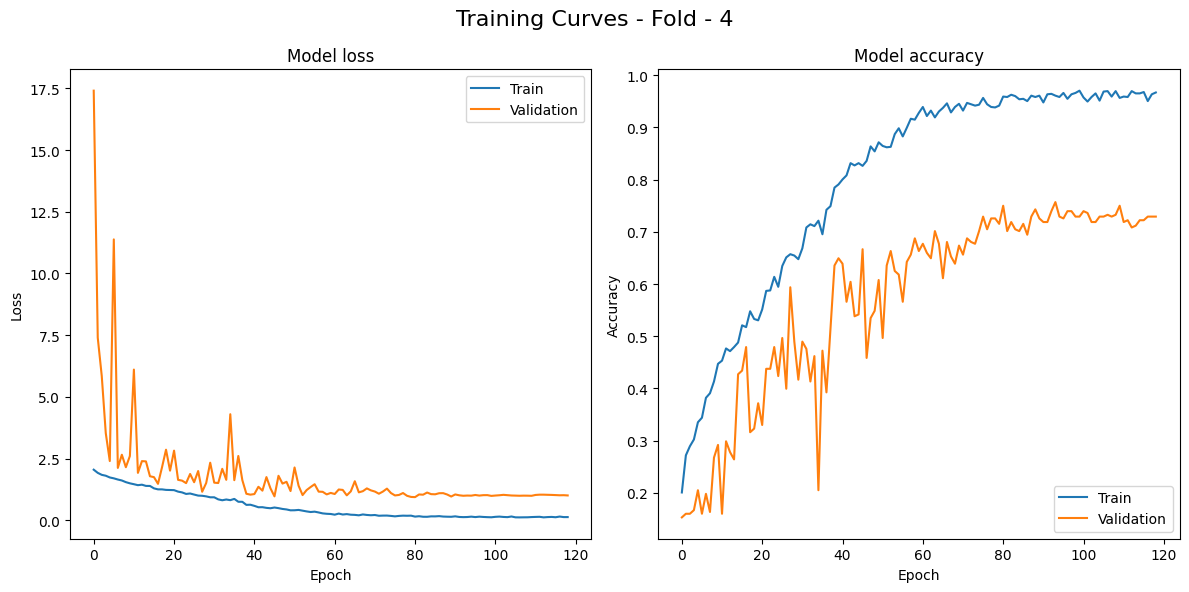

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


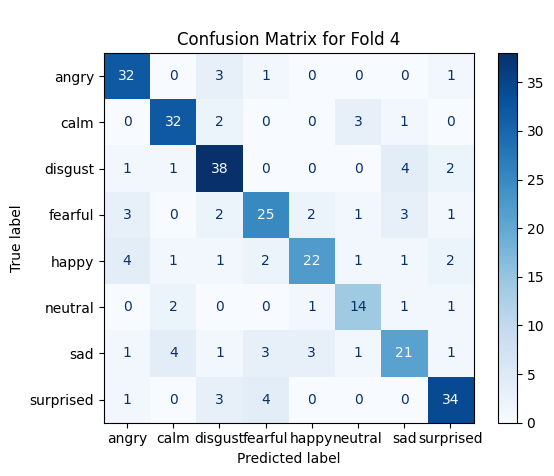


Fold 4 Validation Accuracy: 75.6944%

Training fold 5...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.2021 - loss: 2.0634
Epoch 1: val_accuracy improved from -inf to 0.12153, saving model to /content/drive/MyDrive/PBL_2_Files/Models/best_cnn_model_fold5.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 284ms/step - accuracy: 0.2025 - loss: 2.0627 - val_accuracy: 0.1215 - val_loss: 12.2884 - learning_rate: 0.0010
Epoch 2/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.2678 - loss: 1.9443
Epoch 2: val_accuracy improved from 0.12153 to 0.13889, saving model to /content/drive/MyDrive/PBL_2_Files/Models/best_cnn_model_fold5.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 248ms/step - accuracy: 0.2679 - loss: 1.9441 - val_accuracy: 0.1389 - val_loss: 9.9877 - learning_rate: 0.0010
Epoch 3/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.2777 - loss: 1.8485
Epoch 3: val_accuracy did not improve from 0.13889
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 247ms/step - accuracy: 0.2778 - loss: 1.8490 - val_accuracy: 0.1285 - val_loss: 7.0480 - learn

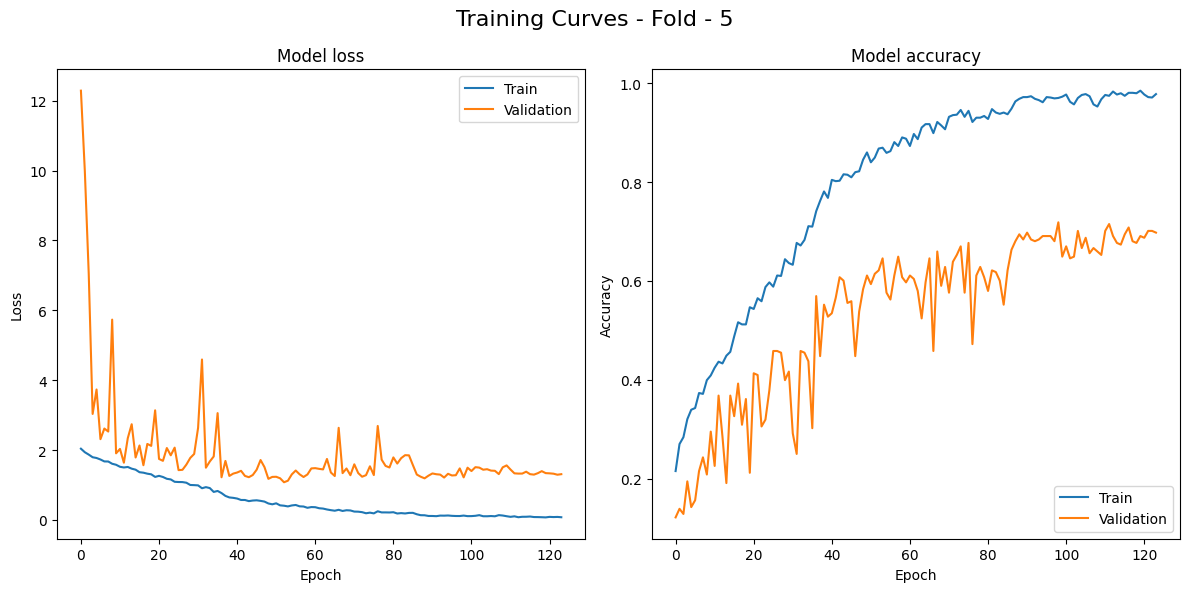

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


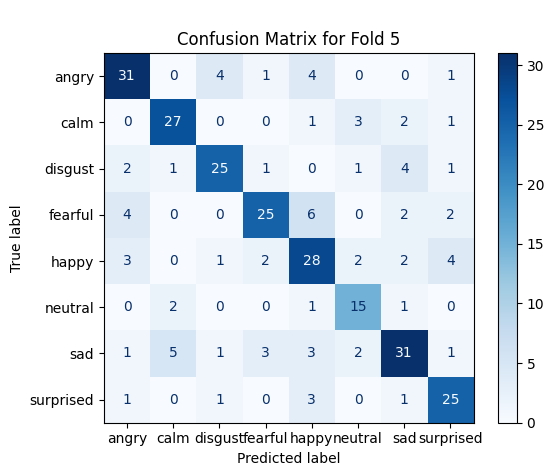


Fold 5 Validation Accuracy: 71.8750%

Average accuracy across 5 folds: 0.7562


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True)
fold_no = 1
histories = []
fold_accuracies = []
le = LabelEncoder()
y_enc = to_categorical(le.fit_transform(labelss))
for train_index, val_index in kf.split(specs):
    print(f"\nTraining fold {fold_no}...")
    X_train, X_val = specs[train_index], specs[val_index]
    y_train, y_val = y_enc[train_index], y_enc[val_index]
    model = create_model()
    mpath = f'/content/drive/MyDrive/PBL_2_Files/Models/best_cnn_model_fold{fold_no}.keras'
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True),
                tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=0.00001),
                tf.keras.callbacks.ModelCheckpoint(filepath=mpath, monitor='val_accuracy', save_best_only=True,verbose=1)]
    histcnn2 = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_val, y_val),callbacks=callbacks)
    plt.figure(figsize=(12, 6))
    plt.suptitle(f"Training Curves - Fold - {fold_no}", fontsize=16)
    plt.subplot(1, 2, 1)
    plt.plot(histcnn2.history['loss'])
    plt.plot(histcnn2.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.subplot(1, 2, 2)
    plt.plot(histcnn2.history['accuracy'])
    plt.plot(histcnn2.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.tight_layout()
    plt.show()
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_val, axis=1)
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'\nConfusion Matrix for Fold {fold_no}')
    plt.show()
    print(f"\nFold {fold_no} Validation Accuracy: {val_accuracy*100:.4f}%")
    histories.append(histcnn2)
    fold_accuracies.append(val_accuracy)
    fold_no += 1
average_accuracy = np.mean(fold_accuracies)
print(f"\nAverage accuracy across {n_splits} folds: {average_accuracy:.4f}")

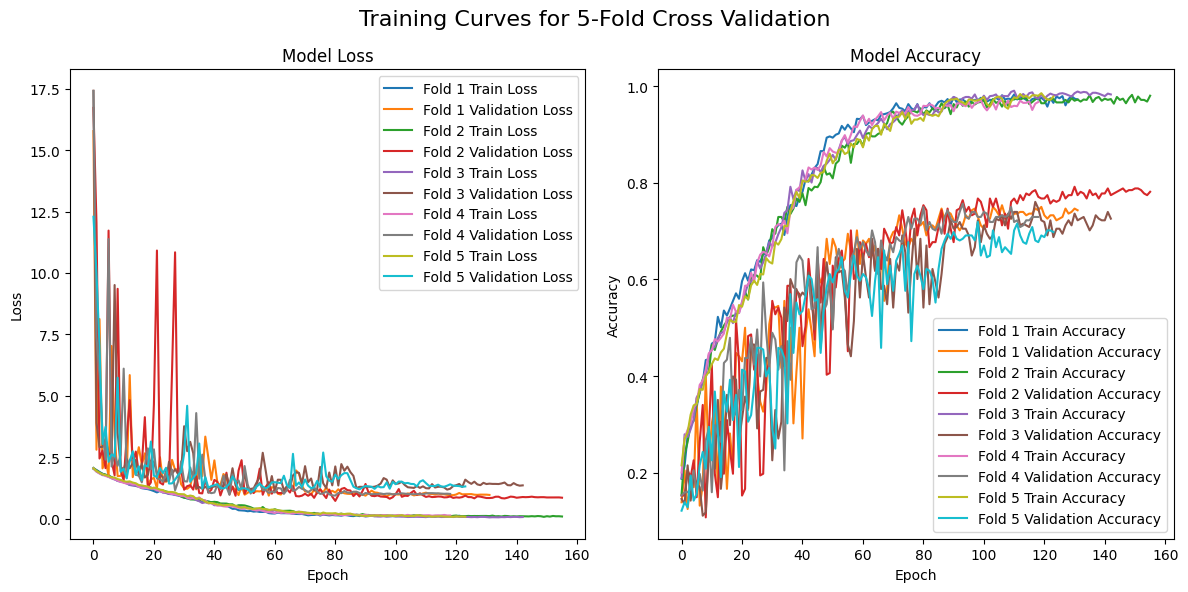

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for i, history in enumerate(histories):
  plt.plot(history.history['loss'], label=f'Fold {i+1} Train Loss')
  plt.plot(history.history['val_loss'], label=f'Fold {i+1} Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
for i, history in enumerate(histories):
  plt.plot(history.history['accuracy'], label=f'Fold {i+1} Train Accuracy')
  plt.plot(history.history['val_accuracy'], label=f'Fold {i+1} Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.suptitle('Training Curves for 5-Fold Cross Validation', fontsize=16)
plt.tight_layout()
plt.show()

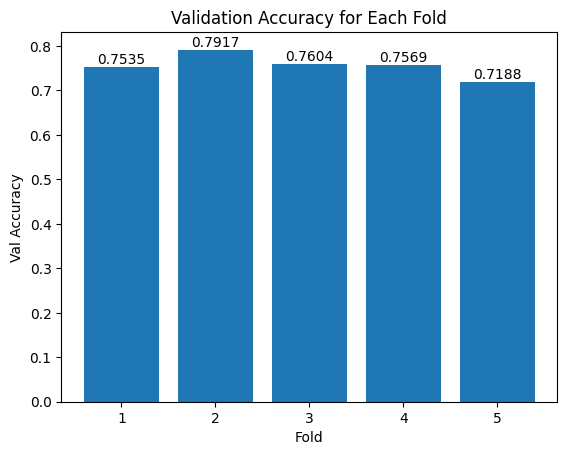

In [ ]:
plt.bar(range(1,n_splits+1),height=fold_accuracies)
plt.xlabel('Fold')
plt.ylabel('Val Accuracy')
plt.title('Validation Accuracy for Each Fold')
for i, val in enumerate(fold_accuracies):
  plt.text(i+1, val, f"{val:.4f}", ha='center', va='bottom')
plt.show()

### **Fine-Tuning ResNet-50 Model on Mel-Spectrograms**

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu',kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu',kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
#x = Dense(128, activation='relu',kernel_regularizer=l2(0.01))(x)
#x = Dropout(0.5)(x)
predictions = Dense(8, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
  layer.trainable = False

le = LabelEncoder()
labels_enc = to_categorical(le.fit_transform(labelss))
train_specs, test_specs, train_labels, test_labels = train_test_split(specs, labels_enc, test_size=0.2, random_state=42)

for layer in base_model.layers[-10:]:
  layer.trainable = True

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12            │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,867,528 (91.05 MB)

 Trainable params: 4,745,480 (18.10 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

#### Monitoring Val_loss; Model with 256 neuron 3 dense layers

In [ ]:
mpath = '/content/drive/MyDrive/PBL_2_Files/Models/best_cnn_model.keras'
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True),
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001),
             tf.keras.callbacks.ModelCheckpoint(filepath=mpath, monitor='val_loss', save_best_only=True,verbose=1)]
histresnet = model.fit(train_specs, train_labels, epochs=500, batch_size=32, validation_data=(test_specs, test_labels),callbacks=callbacks)

_, accuracy = model.evaluate(test_specs, test_labels)
print('\nAccuracy: %.2f' % (accuracy*100))

Epoch 1/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.1378 - loss: 2.5772
Epoch 1: val_loss improved from inf to 1.93333, saving model to /content/drive/MyDrive/PBL_2_Files/Models/best_cnn_model.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 34s 563ms/step - accuracy: 0.1382 - loss: 2.5696 - val_accuracy: 0.2535 - val_loss: 1.9333 - learning_rate: 0.0010
Epoch 2/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.2005 - loss: 2.0107
Epoch 2: val_loss did not improve from 1.93333
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 128ms/step - accuracy: 0.2014 - loss: 2.0092 - val_accuracy: 0.2917 - val_loss: 2.0823 - learning_rate: 0.0010
Epoch 3/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.3222 - loss: 1.7786
Epoch 3: val_loss improved from 1.93333 to 1.63711, saving model to /content/drive/MyDrive/PBL_2_Files/Models/best_cnn_model.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 352ms/step - accuracy: 0.3229 - loss: 1.7771 - val_accuracy: 0.3819 - val_loss: 1.6371 - learning_rate: 0.0010
Epoch 4/

#### Monitoring Val Accuracy,
#### Reduced patience value in early stopping and ReduceLRonPlateau

In [ ]:
mpath = '/content/drive/MyDrive/PBL_2_Files/Models/best_resnet_model.keras'
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True),
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=0.00001),
             tf.keras.callbacks.ModelCheckpoint(filepath=mpath, monitor='val_accuracy', save_best_only=True,verbose=1)]
histresnet = model.fit(train_specs, train_labels, epochs=500, batch_size=32, validation_data=(test_specs, test_labels),callbacks=callbacks)

_, accuracy = model.evaluate(test_specs, test_labels)
print('\nAccuracy: %.2f' % (accuracy*100))

Epoch 1/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.1436 - loss: 2.5325
Epoch 1: val_accuracy improved from -inf to 0.32639, saving model to /content/drive/MyDrive/PBL_2_Files/Models/best_cnn_model.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 31s 477ms/step - accuracy: 0.1440 - loss: 2.5258 - val_accuracy: 0.3264 - val_loss: 2.1237 - learning_rate: 0.0010
Epoch 2/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.2382 - loss: 1.9384
Epoch 2: val_accuracy did not improve from 0.32639
36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 130ms/step - accuracy: 0.2391 - loss: 1.9369 - val_accuracy: 0.2708 - val_loss: 3.5589 - learning_rate: 0.0010
Epoch 3/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.3238 - loss: 1.7790
Epoch 3: val_accuracy improved from 0.32639 to 0.43056, saving model to /content/drive/MyDrive/PBL_2_Files/Models/best_cnn_model.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 250ms/step - accuracy: 0.3242 - loss: 1.7779 - val_accuracy: 0.4306 - val_loss: 1.9401 - learning_rate: 0.0

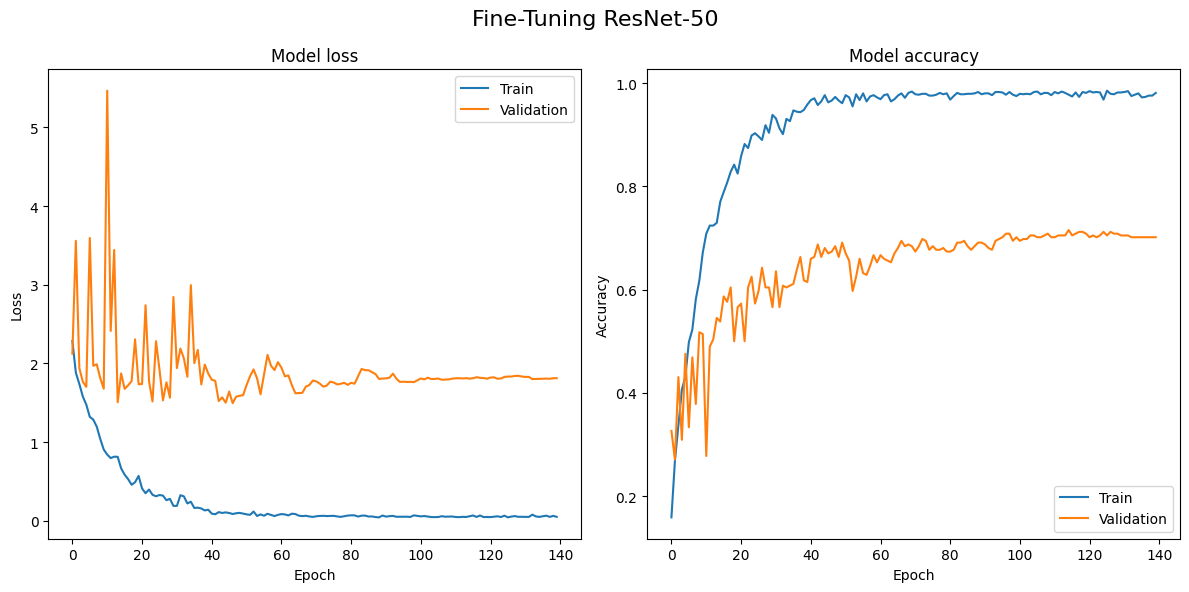

In [ ]:
plt.figure(figsize=(12, 6))
plt.suptitle('Fine-Tuning ResNet-50', fontsize=16)
plt.subplot(1, 2, 1)
plt.plot(histresnet.history['loss'])
plt.plot(histresnet.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(histresnet.history['accuracy'])
plt.plot(histresnet.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.show()

#### Removed one dense layer and reduced dense units from 256 to 128 to reduce overfitting
#### Added an L2 regularizer kernel in dense layers

In [ ]:
mpath = '/content/drive/MyDrive/PBL_2_Files/Models/best_resnet_model.keras'
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True),
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=0.00001),
             tf.keras.callbacks.ModelCheckpoint(filepath=mpath, monitor='val_accuracy', save_best_only=True,verbose=1)]
histresnet = model.fit(train_specs, train_labels, epochs=500, batch_size=32, validation_data=(test_specs, test_labels),callbacks=callbacks)

_, accuracy = model.evaluate(test_specs, test_labels)
print('\nAccuracy: %.2f' % (accuracy*100))

Epoch 1/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.1983 - loss: 5.7807
Epoch 1: val_accuracy improved from -inf to 0.28472, saving model to /content/drive/MyDrive/PBL_2_Files/Models/best_resnet_model.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 28s 318ms/step - accuracy: 0.1984 - loss: 5.7641 - val_accuracy: 0.2847 - val_loss: 5.1587 - learning_rate: 0.0010
Epoch 2/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.3123 - loss: 3.9639
Epoch 2: val_accuracy improved from 0.28472 to 0.30556, saving model to /content/drive/MyDrive/PBL_2_Files/Models/best_resnet_model.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 263ms/step - accuracy: 0.3124 - loss: 3.9580 - val_accuracy: 0.3056 - val_loss: 3.8655 - learning_rate: 0.0010
Epoch 3/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.3436 - loss: 3.1187
Epoch 3: val_accuracy improved from 0.30556 to 0.40625, saving model to /content/drive/MyDrive/PBL_2_Files/Models/best_resnet_model.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 288ms/step - 

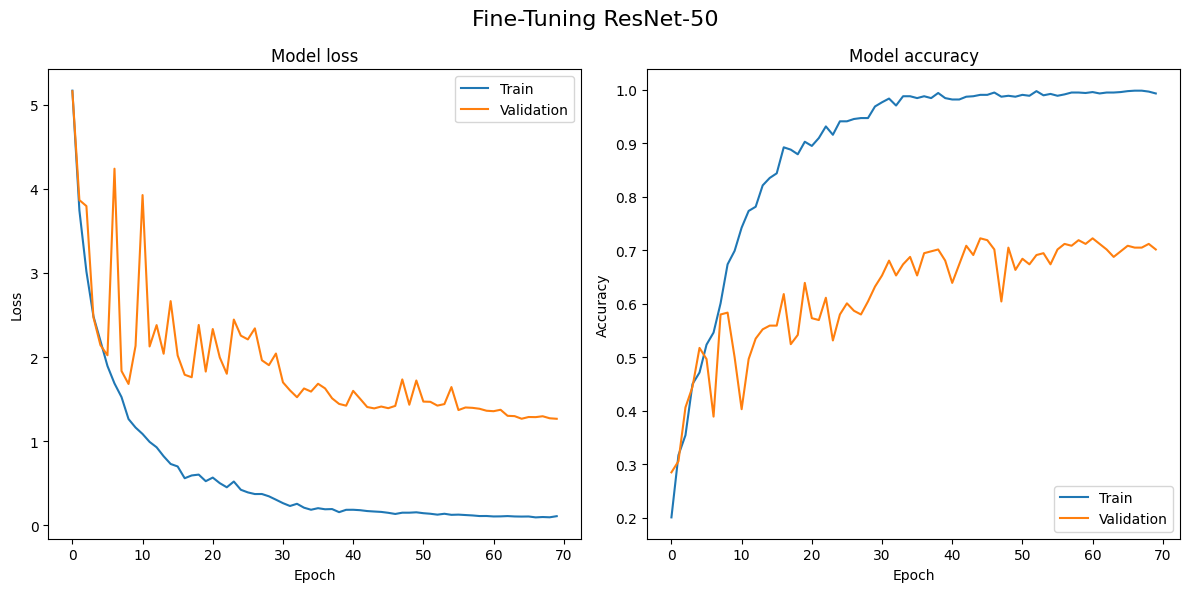

In [ ]:
plt.figure(figsize=(12, 6))
plt.suptitle('Fine-Tuning ResNet-50', fontsize=16)
plt.subplot(1, 2, 1)
plt.plot(histresnet.history['loss'])
plt.plot(histresnet.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(histresnet.history['accuracy'])
plt.plot(histresnet.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.show()
# Model loss decreased from 2.0 to 1.2

#### Trained same model again

In [ ]:
mpath = '/content/drive/MyDrive/PBL_2_Files/Models/best_resnet50_model.keras'
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True),
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=0.00001),
             tf.keras.callbacks.ModelCheckpoint(filepath=mpath, monitor='val_accuracy', save_best_only=True,verbose=1)]
histresnet = model.fit(train_specs, train_labels, epochs=500, batch_size=32, validation_data=(test_specs, test_labels),callbacks=callbacks)

_, accuracy = model.evaluate(test_specs, test_labels)
print('\nAccuracy: %.2f' % (accuracy*100))

Epoch 1/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.1792 - loss: 5.6442
Epoch 1: val_accuracy improved from -inf to 0.22917, saving model to /content/drive/MyDrive/PBL_2_Files/Models/best_resnet_model.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 27s 385ms/step - accuracy: 0.1799 - loss: 5.6276 - val_accuracy: 0.2292 - val_loss: 8.3188 - learning_rate: 0.0010
Epoch 2/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.2755 - loss: 3.8452
Epoch 2: val_accuracy improved from 0.22917 to 0.24306, saving model to /content/drive/MyDrive/PBL_2_Files/Models/best_resnet_model.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 332ms/step - accuracy: 0.2757 - loss: 3.8387 - val_accuracy: 0.2431 - val_loss: 5.7841 - learning_rate: 0.0010
Epoch 3/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.4111 - loss: 2.9149
Epoch 3: val_accuracy improved from 0.24306 to 0.40625, saving model to /content/drive/MyDrive/PBL_2_Files/Models/best_resnet_model.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 178ms/step - 

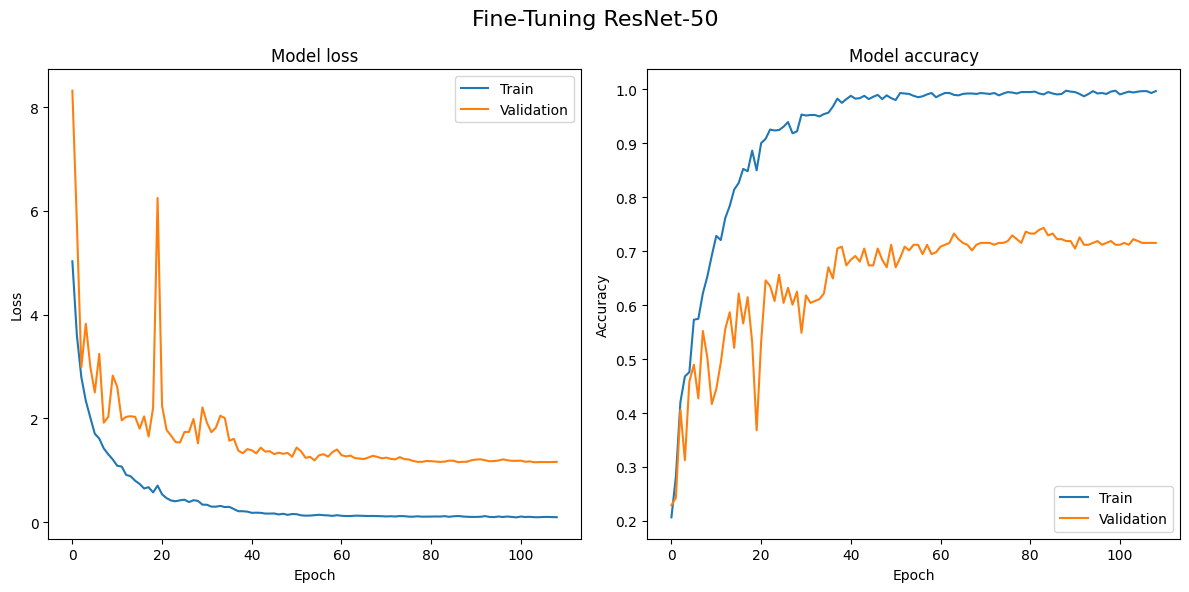

In [ ]:
plt.figure(figsize=(12, 6))
plt.suptitle('Fine-Tuning ResNet-50', fontsize=16)
plt.subplot(1, 2, 1)
plt.plot(histresnet.history['loss'])
plt.plot(histresnet.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(histresnet.history['accuracy'])
plt.plot(histresnet.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.show()
# Overfitting reduced a bit more but still it is overfitting

**Best Validation Accuracy of ResNet50 Model = 74.31%**